## Multivariate decision tree for ligand activity classification

This notebook demonstrates how we screened all possible combinations of three descriptors for ligand activity classification using a multivariate decision tree. This was the final model used to determine ligand activity.

In [9]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

# Load data
df = pd.read_csv("data/ligand-qsar/alkylamine-ligand-modeling.tsv", sep="\t")
df = df[df["buchwald-type"] > 0]

# Define bins and labels
activity_cutoff = 15
bins = [-np.inf, activity_cutoff, np.inf]
labels = ["Low", "High"]
transformer = preprocessing.FunctionTransformer(
    pd.cut, kw_args={"bins": bins, "labels": labels, "retbins": False}
)


# Standardize features
X = df.drop(columns=["ligand_1_name", "product_1_yield"])

# Transform target
y = df["product_1_yield"]
y_bin = transformer.fit_transform(y)

In [10]:
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold


def evaluate_model(clf, X, y_bin):
    """Evaluate a model using cross-validation."""
    clf.fit(X, y_bin)
    preds = clf.predict(X)
    print(f"Accuracy: {metrics.accuracy_score(y_bin, preds):0.2f}")
    print(f"F1: {metrics.f1_score(y_bin, preds, pos_label='High'):0.2f}")
    print(f"MCC: {metrics.matthews_corrcoef(y_bin, preds):0.2f}")
    print("Confusion matrix:\n", metrics.confusion_matrix(y_bin, preds))
    print(f"Incorrect ligands: {df.loc[y_bin != preds, 'ligand_1_name'].tolist()}")
    print()

    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
    kfold_f1s = []
    kfold_mccs = []
    for train_index, test_index in kfold.split(X, y_bin):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_bin[train_index], y_bin[test_index]

        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

        f1_k = metrics.f1_score(y_test, preds, pos_label="High")
        kfold_f1s.append(f1_k)

        mcc_k = metrics.matthews_corrcoef(y_test, preds)
        kfold_mccs.append(mcc_k)

    kfold_f1 = round(np.mean(kfold_f1s), 2)
    kfold_mcc = round(np.mean(kfold_mccs), 2)

    print(f"K-fold F1: {kfold_f1}")
    print(f"K-fold MCC: {kfold_mcc}")
    print()

In [11]:
from itertools import combinations

from joblib import Parallel, delayed
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

run = False


def evaluate_combination(features: tuple, n_depth: int = 3):
    """Evaluate a combination of features."""
    clf = DecisionTreeClassifier(
        random_state=42, class_weight="balanced", max_depth=n_depth
    )
    clf.fit(X[list(features)], y_bin)
    f1 = round(
        metrics.f1_score(y_bin, clf.predict(X[list(features)]), pos_label="High"), 2
    )
    if f1 < 0.7:
        return (features, f1, 0)

    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
    kfold_f1s = []
    kfold_mccs = []
    for train_index, test_index in kfold.split(X, y_bin):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_bin[train_index], y_bin[test_index]

        clf.fit(X_train[list(features)], y_train)
        preds = clf.predict(X_test[list(features)])

        f1_k = metrics.f1_score(y_test, preds, pos_label="High")
        kfold_f1s.append(f1_k)

        mcc_k = metrics.matthews_corrcoef(y_test, preds)
        kfold_mccs.append(mcc_k)

    kfold_f1 = round(np.mean(kfold_f1s), 2)

    return (features, f1, kfold_f1)

In [12]:
n_depth = 3
combinations_list = list(combinations(X.columns, 3))

print(f"Number of combinations: {len(combinations_list)}")

if run:
    results = Parallel(n_jobs=-1)(
        delayed(evaluate_combination)(features, n_depth)
        for features in tqdm(combinations_list)
    )

    results = sorted(results, key=lambda x: x[2], reverse=True)
    for features, f1, kfold_f1 in results[:10]:
        print(f"Features: {features}, F1: {f1}, K-Fold F1: {kfold_f1}")

Number of combinations: 585276


In [13]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(
    rc={"figure.figsize": (5, 5), "figure.dpi": 150}, style="ticks", font_scale=1.2
)

if run:
    print(list(results[0][0]))
    X_feat = X[list(results[0][0])]
else:
    X_feat = X[["partial_charge_metal", "max_buried_volume_3.5A", "max_P_int_ligand"]]

clf = DecisionTreeClassifier(
    random_state=0,
    class_weight="balanced",
    max_depth=n_depth,
)

evaluate_model(clf, X_feat, y_bin)
clf.fit(X_feat, y_bin)

Accuracy: 0.99
F1: 0.95
MCC: 0.94
Confusion matrix:
 [[ 9  0]
 [ 1 86]]
Incorrect ligands: ['L-094']

K-fold F1: 0.92
K-fold MCC: 0.92



DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=0)

/home/nhadler/projects/abbvie-cn-couplings/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


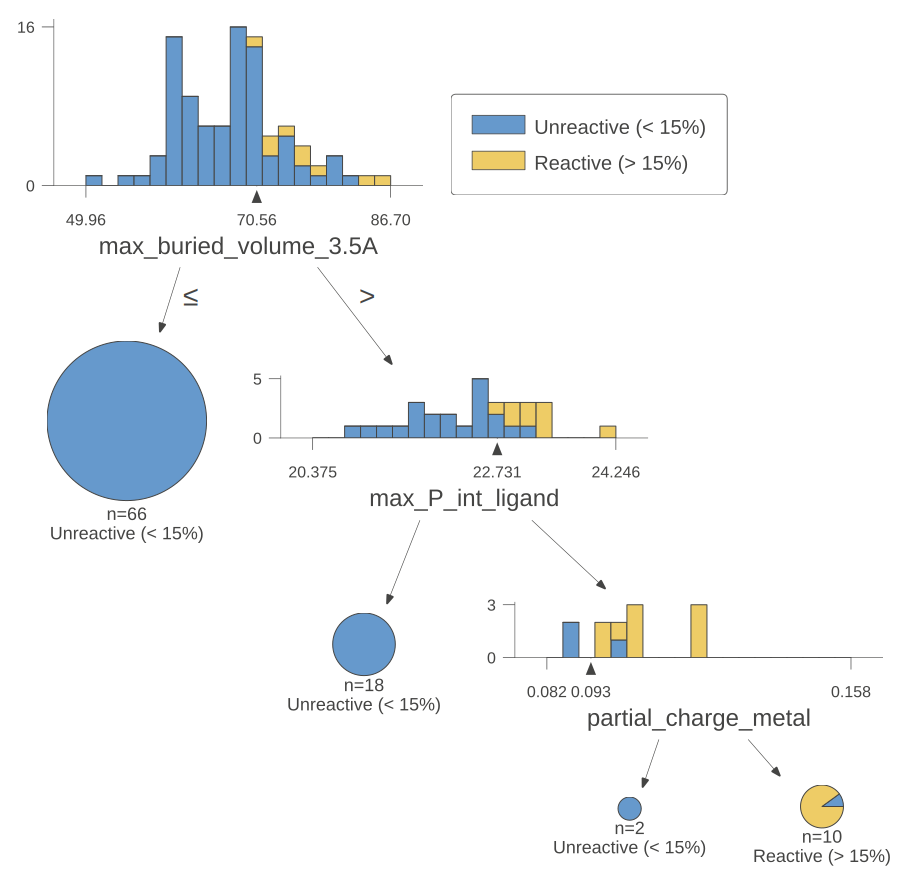

In [19]:
import dtreeviz

# Convert y_bin to numeric values
y_bin_numeric = y_bin.map({"Low": 0, "High": 1}).values

X_feat = X_feat.round(3)
clf.fit(X_feat, y_bin_numeric)


viz_model = dtreeviz.model(
    clf,
    X_train=X_feat,
    y_train=y_bin_numeric,
    feature_names=X_feat.columns,
    class_names=["Unreactive (< 15%)", "Reactive (> 15%)"],
)

class_colors = [
    None,  # 0 classes
    None,  # 1 class
    ["#69C", "#EC6"],  # 2 classes
]

v = viz_model.view(
    fontname="liberation sans",
    scale=2.0,
    show_root_edge_labels=True,
    colors=dict(classes=class_colors),
)

v

### Control Experiment

Y-Shuffle Control

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

sns.set_theme(
    rc={"figure.figsize": (5, 5), "figure.dpi": 150}, style="ticks", font_scale=1.2
)

run = False
if run:
    print(list(results[0][0]))
    X_feat = X[list(results[0][0])]
else:
    X_feat = X[["partial_charge_metal", "max_buried_volume_3.5A", "max_P_int_ligand"]]

clf = DecisionTreeClassifier(
    random_state=0,
    class_weight="balanced",
    max_depth=3,
)

y_bin_shuffle = y_bin.sample(frac=1, random_state=0)
evaluate_model(clf, X_feat, y_bin_shuffle)

Accuracy: 0.95
F1: 0.71
MCC: 0.68
Confusion matrix:
 [[ 6  3]
 [ 2 85]]
Incorrect ligands: ['L-061', 'L-101', 'L-124', 'L-145', 'L-146']

K-fold F1: 0.64
K-fold MCC: 0.64



/home/nhadler/projects/abbvie-cn-couplings/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
/home/nhadler/projects/abbvie-cn-couplings/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.


X-Randomization Control

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

sns.set_theme(
    rc={"figure.figsize": (5, 5), "figure.dpi": 150}, style="ticks", font_scale=1.2
)

run = False
if run:
    print(list(results[0][0]))
    X_feat = X[list(results[0][0])]
else:
    X_feat = X[["partial_charge_metal", "max_buried_volume_3.5A", "max_P_int_ligand"]]

clf = DecisionTreeClassifier(
    random_state=0,
    class_weight="balanced",
    max_depth=3,
)


def generate_random_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Generate a random dataframe with the same shape and distribution as the input dataframe.

    This function ensures that each column's random data matches the original min and max values.

    Args:
        df (pd.DataFrame): DataFrame to generate random data from.

    Returns:
        pd.DataFrame: DataFrame with random data.
    """
    np.random.seed(0)
    df = df.copy()
    for col in df.columns:
        df[col] = np.random.uniform(
            low=df[col].min(), high=df[col].max(), size=df[col].shape
        )
    return df


X_feat_rand = generate_random_dataframe(X_feat)

evaluate_model(clf, X_feat_rand, y_bin)

Accuracy: 0.61
F1: 0.33
MCC: 0.34
Confusion matrix:
 [[ 9  0]
 [37 50]]
Incorrect ligands: ['L-006', 'L-010', 'L-011', 'L-012', 'L-016', 'L-021', 'L-029', 'L-032', 'L-037', 'L-061', 'L-062', 'L-070', 'L-071', 'L-077', 'L-078', 'L-079', 'L-082', 'L-085', 'L-087', 'L-089', 'L-091', 'L-094', 'L-095', 'L-099', 'L-110', 'L-114', 'L-115', 'L-117', 'L-118', 'L-124', 'L-132', 'L-133', 'L-134', 'L-137', 'L-140', 'L-141', 'L-142']

K-fold F1: 0.14
K-fold MCC: -0.04

